In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
# 라이브러리
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 폰트 깨짐 방지
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

#### 데이터 불러오기

In [31]:
data_iter = pd.read_csv('/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/기상/기상보간iter.csv', encoding='UTF-8')
data_linear = pd.read_csv('/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/기상/기상보간linear.csv', encoding='UTF-8')

In [32]:
data_iter['Year'] = data_iter['일시'].str.split('-').str[0].astype('int')
data_linear['Year'] = data_linear['일시'].str.split('-').str[0].astype('int')

In [33]:
data_iter.set_index('일시',inplace = True)
data_linear.set_index('일시',inplace = True)

#### 추세 / 계절성 / 시계열 그래프
- trend : 존재
- seasonality : 존재

*결과 : non-stationary TS*

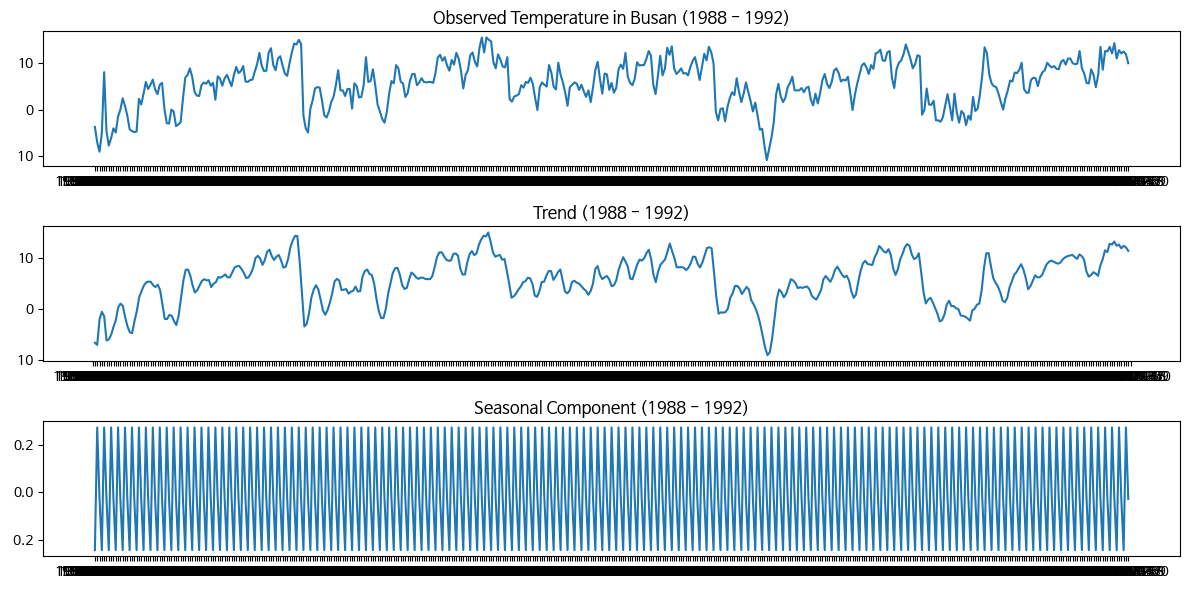

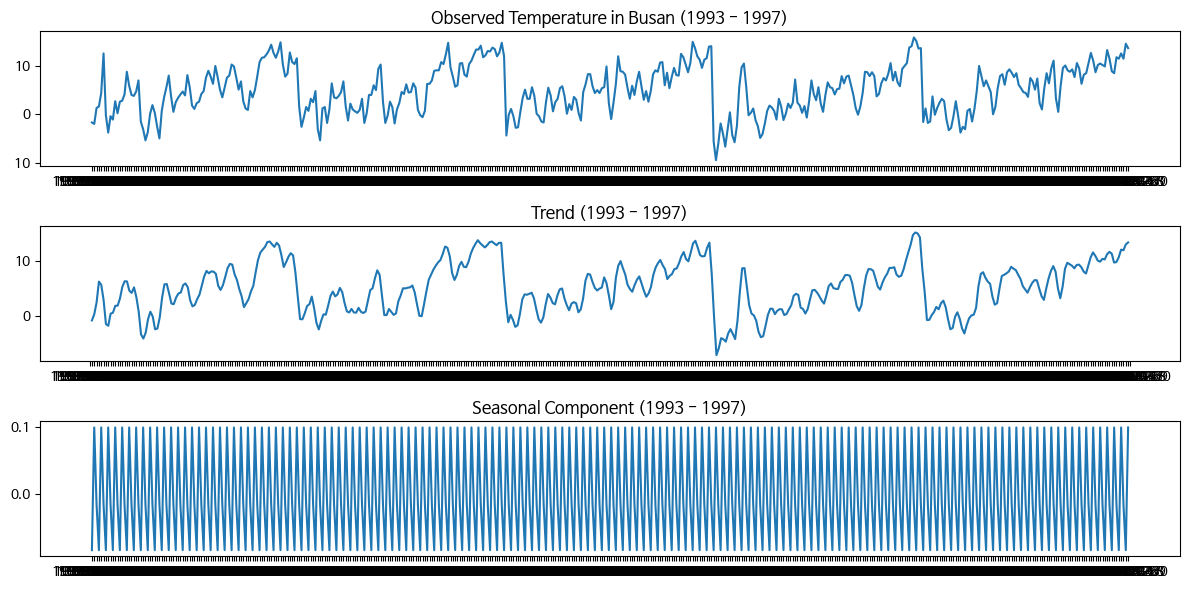

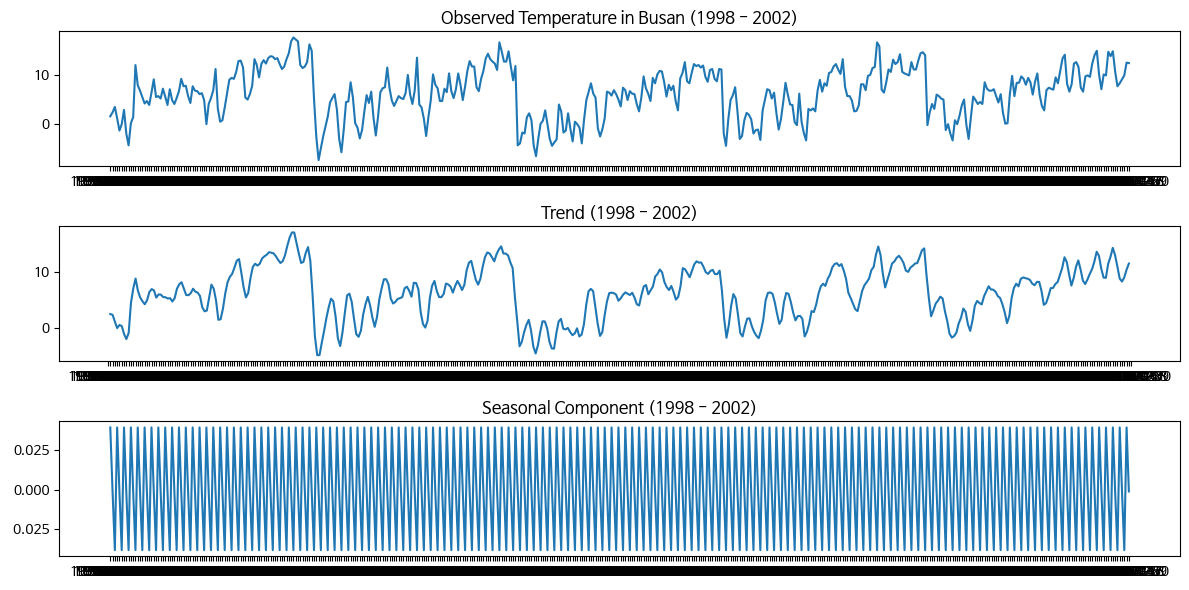

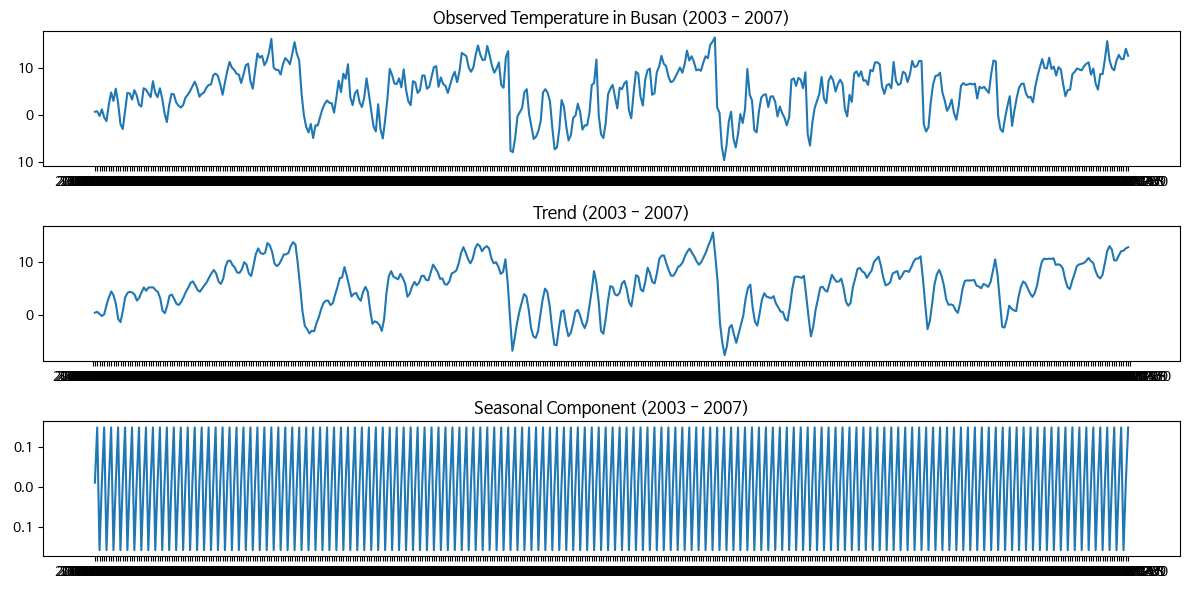

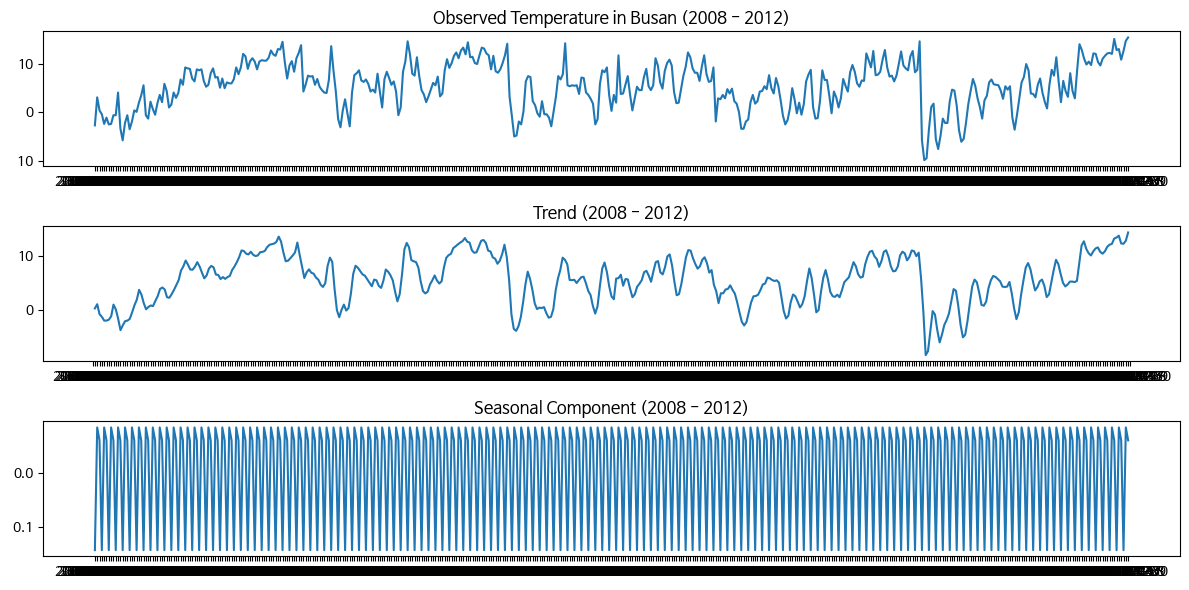

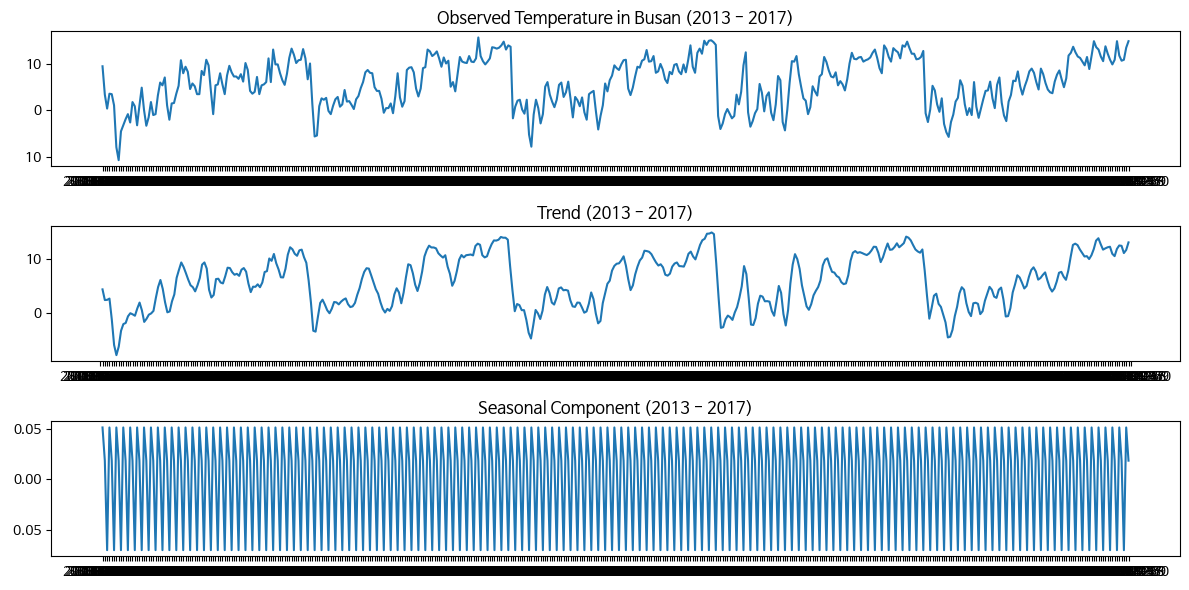

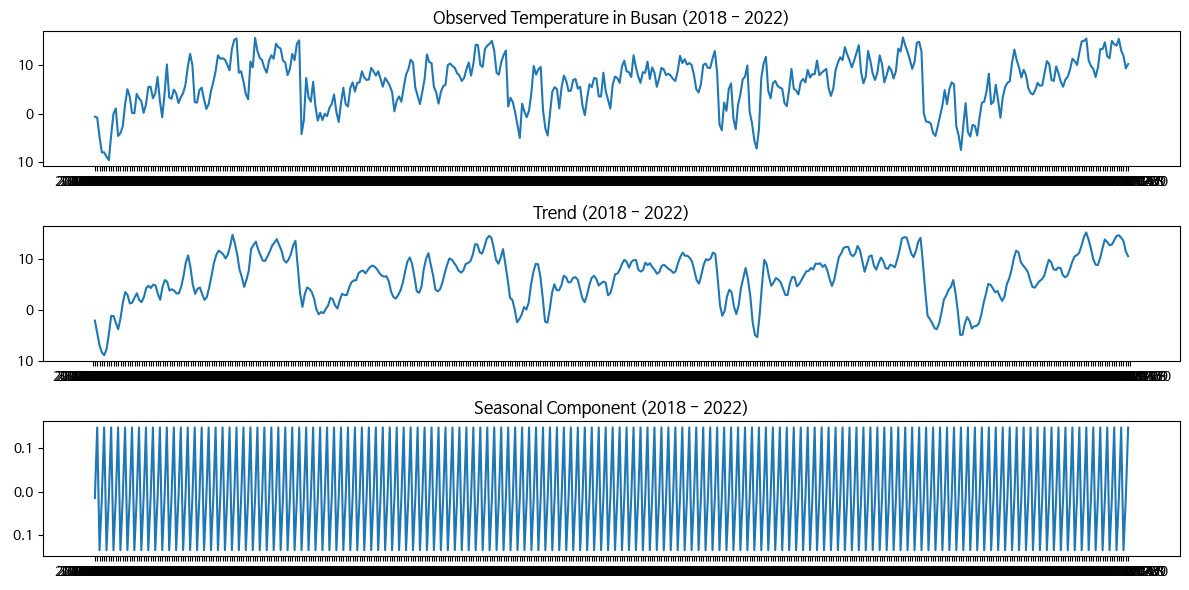

In [47]:
def plot_seasonal_decomposition_by_5_years(data, start_year, end_year, period=3):
    results = []
    original_start_year = start_year

    while start_year <= end_year - 5:
        current_data = data['최저기온(°C)'][(data['Year'] >= start_year) & (data['Year'] < start_year + 5)
                                          & (data['해양'] == 1) & (data['지점명'] == '부산')]
        result = seasonal_decompose(current_data, model='additive', period=period)
        results.append(result)
        start_year += 5

    for i, result in enumerate(results):
        start_year_i = original_start_year + i * 5
        end_year_i = start_year_i + 4

        plt.figure(figsize=(12, 6))
        plt.subplot(3, 1, 1)
        plt.plot(result.observed)
        plt.title(f'Observed Temperature in Busan ({start_year_i} - {end_year_i})')

        plt.subplot(3, 1, 2)
        plt.plot(result.trend)
        plt.title(f'Trend ({start_year_i} - {end_year_i})')

        plt.subplot(3, 1, 3)
        plt.plot(result.seasonal)
        plt.title(f'Seasonal Component ({start_year_i} - {end_year_i})')

        plt.tight_layout()
        plt.show()


plot_seasonal_decomposition_by_5_years(data_iter, start_year=1988, end_year=2023, period=3)

#### 정상성 검정
- ACF & PACF

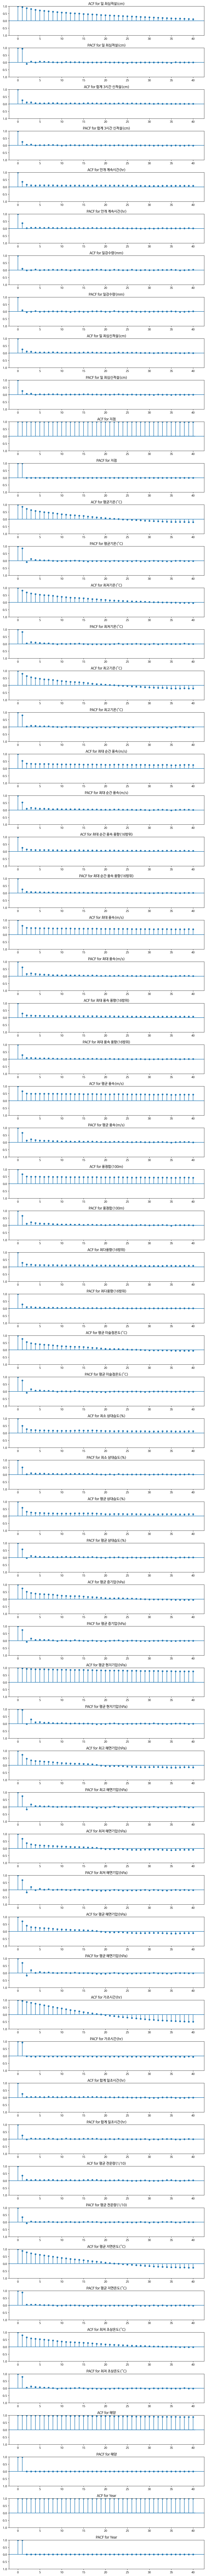

In [62]:
def plot_acf_pacf(data, lags=40):
    columns = data.columns

    fig, axes = plt.subplots(len(columns) * 2, 1, figsize=(10, 4 * len(columns)))

    for i, column in enumerate(columns):

        plot_acf(data[column], lags=lags, ax=axes[i * 2])
        axes[i * 2].set_title(f'ACF for {column}')

        plot_pacf(data[column], lags=lags, ax=axes[i * 2 + 1])
        axes[i * 2 + 1].set_title(f'PACF for {column}')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(data_iter.drop(['지점명'],axis=1), lags=40)

In [58]:
def plot_acf_pacf(data, columns, lags = 40):

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(data[columns], lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Generate PACF plot
    plot_pacf(data[columns], lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

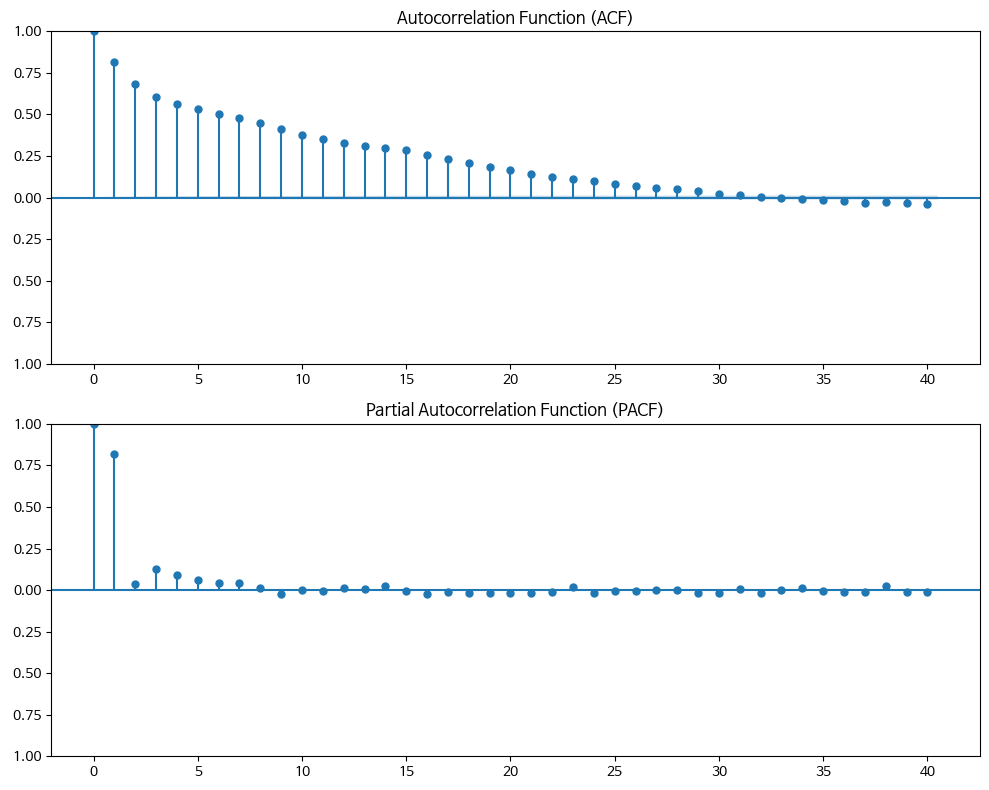

In [60]:
plot_acf_pacf(data_iter,'최저기온(°C)')

In [55]:
data_iter.columns

Index(['일 최심적설(cm)', '합계 3시간 신적설(cm)', '안개 계속시간(hr)', '일강수량(mm)',
       '일 최심신적설(cm)', '지점', '지점명', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)',
       '최대 순간 풍속(m/s)', '최대 순간 풍속 풍향(16방위)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)',
       '평균 풍속(m/s)', '풍정합(100m)', '최다풍향(16방위)', '평균 이슬점온도(°C)', '최소 상대습도(%)',
       '평균 상대습도(%)', '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)',
       '최저 해면기압(hPa)', '평균 해면기압(hPa)', '가조시간(hr)', '합계 일조시간(hr)',
       '평균 전운량(1/10)', '평균 지면온도(°C)', '최저 초상온도(°C)', '해양', 'Year'],
      dtype='object')

In [53]:
def multivariate_stationarity_test(df):
    stationary = True
    for col in tqdm(df.columns):
        valid_data = df.dropna(subset=[col])
        result = adfuller(valid_data[col])
        p_value = result[1]
        if p_value > 0.05:
            print(f"{col} 변수: ADF 검정 p-값 = {p_value} (정상성을 만족하지 않음)")
            stationary = False
        else:
            print(f"{col} 변수: ADF 검정 p-값 = {p_value} (정상성을 만족)")
    return stationary

is_stationary = multivariate_stationarity_test(data_iter)

if is_stationary:
    print("다변량 시계열 데이터는 정상성을 만족합니다.")
else:
    print("다변량 시계열 데이터는 정상성을 만족하지 않습니다.")

  0%|          | 0/32 [02:57<?, ?it/s]


KeyboardInterrupt: ignored